# Baseline

leaderboard : 549.79296906532

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 500)

### load dataset

In [2]:
DATA_DIR = '../../dataset/input/'
train_raw = pd.read_csv(DATA_DIR + 'train.csv')
test_raw = pd.read_csv(DATA_DIR + 'test.csv')

In [3]:
train_raw.head()

,holiday,temperature,rain_in_hour,snow_in_hour,clouds_cover,weather,weather_detail,timestamp,traffic_volume
0,New Years Day,263.49,0.0,0.0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439
1,None,263.78,0.0,0.0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502
2,None,264.16,0.0,0.0,75,Snow,heavy snow,2013-01-01 02:00:00,933
3,None,263.95,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576
4,None,263.65,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372


In [4]:
test_raw.head()

,holiday,temperature,rain_in_hour,snow_in_hour,clouds_cover,weather,weather_detail,timestamp
0,New Years Day,249.36,0.0,0.0,1,Clear,sky is clear,2018-01-01 00:00:00
1,None,249.08,0.0,0.0,1,Clear,sky is clear,2018-01-01 01:00:00
2,None,248.86,0.0,0.0,1,Clear,sky is clear,2018-01-01 02:00:00
3,None,248.72,0.0,0.0,1,Clear,sky is clear,2018-01-01 03:00:00
4,None,248.43,0.0,0.0,1,Clear,sky is clear,2018-01-01 04:00:00


In [5]:
print("shape of train df : ", train_raw.shape)
print("shape of test df : ", test_raw.shape)

shape of train df :  (37696, 9)
shape of test df :  (7949, 8)


### preprocess

In [6]:
# remove irregular data
train_raw = train_raw[train_raw['temperature'] != 0]
train_raw = train_raw[train_raw['rain_in_hour']  != 9831.30]

In [7]:
train_raw.shape

(37685, 9)

In [8]:
# feature enginnering from timestamp
def preprocessor_for_date(df):
    # basic
    df['date'] = pd.to_datetime(df['timestamp'])
    df['Year'] = df['date'].apply(lambda x: x.year)
    df['Month'] = df['date'].apply(lambda x: x.month)
    df['Day'] = df['date'].apply(lambda x: x.day)
    df['Hour'] = df['date'].apply(lambda x: x.hour)
    df['DayOfWeek'] = df['date'].apply(lambda x: x.dayofweek)
    df['DayOfYear'] = df['date'].apply(lambda x: x.dayofyear)
    df['WeekOfYear'] = df['date'].apply(lambda x: x.weekofyear)
    df['WeekOfMonth'] = df['date'].apply(lambda x: x.day // 7 + 1)
    df['Quarter'] = df['date'].apply(lambda x: x.quarter)
    return df

train_raw = preprocessor_for_date(train_raw)
test_raw = preprocessor_for_date(test_raw)

In [9]:
# fill correct value for holidays column
def preprocessor_for_holidays(df):
    df['date'] = pd.to_datetime(df['timestamp'])
    holidays_col = df[df['holiday'] != 'None']
    for holiday, date in zip(holidays_col['holiday'], holidays_col['date']):
        df['holiday'].mask((df['date'] > date) & (df['date'] < date +  timedelta(days=1)), holiday, inplace=True)
    return df

train_raw = preprocessor_for_holidays(train_raw)
test_raw = preprocessor_for_holidays(test_raw)

In [10]:
# for category value
def preprocessor_for_category_values(df):
    df['holiday'] = df['holiday'].astype('category')
    df['weather'] = df['weather'].astype('category')
    df['weather_detail'] = df['weather_detail'].astype('category')
    return df

train_raw = preprocessor_for_category_values(train_raw)
test_raw = preprocessor_for_category_values(test_raw)

In [11]:
train_raw.head()

,holiday,temperature,rain_in_hour,snow_in_hour,clouds_cover,weather,weather_detail,timestamp,traffic_volume,date,Year,Month,Day,Hour,DayOfWeek,DayOfYear,WeekOfYear,WeekOfMonth,Quarter
0,New Years Day,263.49,0.0,0.0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439,2013-01-01 00:00:00,2013,1,1,0,1,1,1,1,1
1,New Years Day,263.78,0.0,0.0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502,2013-01-01 01:00:00,2013,1,1,1,1,1,1,1,1
2,New Years Day,264.16,0.0,0.0,75,Snow,heavy snow,2013-01-01 02:00:00,933,2013-01-01 02:00:00,2013,1,1,2,1,1,1,1,1
3,New Years Day,263.95,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576,2013-01-01 03:00:00,2013,1,1,3,1,1,1,1,1
4,New Years Day,263.65,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372,2013-01-01 04:00:00,2013,1,1,4,1,1,1,1,1


### train
#### 学習条件
* 目的変数
  * 対数変換
  * 標準化もあとで試す
* validation
  * 2017年の全データ
  * LGBMのパラメータを決定
* 全データで再学習もしてみる

In [12]:
# prepare dataset
all_columns = list(train_raw.columns)
ignore_columns = ['timestamp', 'date']
target_columns = ['traffic_volume']
train_columns = [val for val in all_columns if val not in (ignore_columns + target_columns)]
train_feature = train_raw[train_columns]
train_target = train_raw[target_columns]
test_feature = test_raw[train_columns]

In [13]:
train_feature.head()

,holiday,temperature,rain_in_hour,snow_in_hour,clouds_cover,weather,weather_detail,Year,Month,Day,Hour,DayOfWeek,DayOfYear,WeekOfYear,WeekOfMonth,Quarter
0,New Years Day,263.49,0.0,0.0,58,Clouds,broken clouds,2013,1,1,0,1,1,1,1,1
1,New Years Day,263.78,0.0,0.0,40,Clouds,scattered clouds,2013,1,1,1,1,1,1,1,1
2,New Years Day,264.16,0.0,0.0,75,Snow,heavy snow,2013,1,1,2,1,1,1,1,1
3,New Years Day,263.95,0.0,0.0,90,Clouds,overcast clouds,2013,1,1,3,1,1,1,1,1
4,New Years Day,263.65,0.0,0.0,90,Clouds,overcast clouds,2013,1,1,4,1,1,1,1,1


In [14]:
print("Equal train feature dim to test feature dim : ", train_feature.shape[1] == test_feature.shape[1])

Equal train feature dim to test feature dim :  True


In [15]:
split_id = train_feature[train_feature['Year'] < 2017].shape[0]
X_valid, X_train= train_feature[0:split_id], train_feature[split_id:]
y_valid, y_train = train_target[0:split_id], train_target[split_id:]

In [16]:
# LGBMの学習
categorical_features = ['holiday', 'weather', 'weather_detail']
lgb_train = lgb.Dataset(X_train, np.log(y_train + 1), categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, np.log(y_valid + 1), categorical_feature=categorical_features)

# n_estimators以外は全てデフォルト
params = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "seed": 1234, 
    "n_estimators": 1000,
}

# train
gbm = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=50)

[1]	valid_0's l2: 0.830575
Training until validation scores don't improve for 50 rounds


/Users/nishikawadaiki/code/github.com/nd-02110114/traffic-prediction/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nishikawadaiki/code/github.com/nd-02110114/traffic-prediction/venv/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[2]	valid_0's l2: 0.696856
[3]	valid_0's l2: 0.588103
[4]	valid_0's l2: 0.499815
[5]	valid_0's l2: 0.427996
[6]	valid_0's l2: 0.369161
[7]	valid_0's l2: 0.321823
[8]	valid_0's l2: 0.283175
[9]	valid_0's l2: 0.251349
[10]	valid_0's l2: 0.22583
[11]	valid_0's l2: 0.204545
[12]	valid_0's l2: 0.187444
[13]	valid_0's l2: 0.173183
[14]	valid_0's l2: 0.161562
[15]	valid_0's l2: 0.152129
[16]	valid_0's l2: 0.144508
[17]	valid_0's l2: 0.138169
[18]	valid_0's l2: 0.132853
[19]	valid_0's l2: 0.12855
[20]	valid_0's l2: 0.124772
[21]	valid_0's l2: 0.121746
[22]	valid_0's l2: 0.119222
[23]	valid_0's l2: 0.117186
[24]	valid_0's l2: 0.115072
[25]	valid_0's l2: 0.11346
[26]	valid_0's l2: 0.112192
[27]	valid_0's l2: 0.110998
[28]	valid_0's l2: 0.11007
[29]	valid_0's l2: 0.109256
[30]	valid_0's l2: 0.108623
[31]	valid_0's l2: 0.10814
[32]	valid_0's l2: 0.107658
[33]	valid_0's l2: 0.107268
[34]	valid_0's l2: 0.107014
[35]	valid_0's l2: 0.106597
[36]	valid_0's l2: 0.106324
[37]	valid_0's l2: 0.106158
[38]	

In [17]:
# validation
y_valid_log_pred = gbm.predict(X_valid)
y_valid_pred = np.exp(y_valid_log_pred) - 1
error = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print('Valid score : ', error)

Valid score :  446.25913144062747


#### feature importance

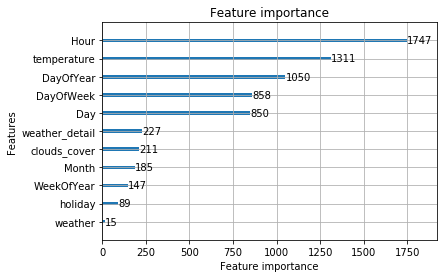

In [18]:
lgb.plot_importance(gbm)

In [19]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), train_columns), reverse=True), columns=['Value','Feature'])
feature_imp

,Value,Feature
0,1747,Hour
1,1311,temperature
2,1050,DayOfYear
3,858,DayOfWeek
4,850,Day
5,227,weather_detail
6,211,clouds_cover
7,185,Month
8,147,WeekOfYear
9,89,holiday


### submission

In [20]:
y_test_log_pred = gbm.predict(test_feature)
y_test_pred = np.exp(y_test_log_pred) - 1

#save predictions in rows
save_path = './submission/bl{}.txt'.format(9263289631)
np.savetxt(save_path, y_test_pred.T)